In [80]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa
from cycler import cycler
import scipy
import seaborn as sns

import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
from scipy.signal import savgol_filter
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot


#own libary
import nsidc



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
#SELECT BOUNDS AND START / END DATES
bounds = [( -19., 20.),
          (-11., 27.),
         ]

# start_date = datetim.datetime(2002, 5, 29) # Start of the AMSR-E period
# start_date = datetime.datetime(2004, 1, 1) # date after data recovery
# end_date = datetime.datetime(2009, 12, 31)  # only a few days to make a demonstration
# end_date = datetime.datetime(2004, 6, 30)  # use this end date to cover the whole AMSR-E period.
# end_date = datetime.datetime(2002, 1, 2)

#---------------------------#---------------------------#---------------------------#---------------------------#

#Select set of POI's to use

# points = pd.read_csv('poizambeziplain.csv')   #Kalabo (weinig goede resultaten)
points = pd.read_csv('poi_senaga.csv')
# points = pd.read_csv('POIs_RE.csv')
# points = pd.read_csv('POIs_RE_3p.csv')


#adjust according to number of points in POI's
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1]),
                   (points.xcoord[2],points.ycoord[2]),
                   (points.xcoord[3],points.ycoord[3]),
                   (points.xcoord[4],points.ycoord[4])]
#                    (points.xcoord[5],points.ycoord[5])]
#                    (points.xcoord[6],points.ycoord[6]) 


# Download discharge data, no adjustment 
dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',parse_dates=['DATE'],index_col = ['DATE'],na_filter=True)

#---------------------------#---------------------------#---------------------------#---------------------------#

# DOWNLOAD THE CORRECT DATA
# This cell calls the right download and "glues" the years together. 

fns=None


year = 2004  #change year to select specific year to see [2002-2011]

# 25 km resolution PMSR DATA
# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/*.nc') # select this line to get the whole AMSR-E period

# 3.125 km resolution PMSR DATA

# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/*.nc') # select this line to get the whole AMSR-E period




fns.sort()
ds = xr.open_mfdataset(fns[0:10])

#---------------------------#---------------------------#---------------------------#---------------------------#

# Discharge data location
# location = 'Kalabo'  
location = 'Senanga'
# location = 'Lukulu'


#---------------------------#---------------------------#---------------------------#---------------------------#


# TRANSFORMING, NO ADJUSTMENT NEEDED
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
bounds_xy = nsidc.proj_coords(bounds, proj_out, proj_in)
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)
points_x, points_y = zip(*points_xy)

#---------------------------#---------------------------#---------------------------#---------------------------#
shift =7




<ipython-input-90-9f4d7fc587ea>:60: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fns[0:10])
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/xarray/backends/api.py:926: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:

<ipython-input-91-e656ae8a71e8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)


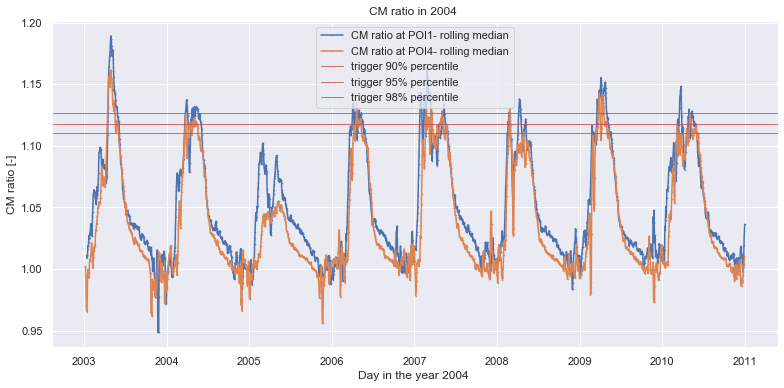

Timedelta('-3 days +00:00:00')

In [91]:
# plotting the data at SENANGA
# shift =7

import nsidc

plt.figure(figsize=(13,6))  
sns.set()

first_threshold_exceedance = {}

df = pd.DataFrame()


for n in [x for x in range(5) if x !=0 if x !=2 if x !=3]: 
    x, y  = points_xy[n]
    C, M, ratio,  = nsidc.c_m_ratio(ds['TB'], x, y)
    
    df[n] = ratio
    dates = ratio.time.values
    
    
    df[n].fillna(method='bfill',inplace=True)
    df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
    df[n] = df[n].rolling(6,center=False).mean() #.shift(10)  # apply and set the rolling median to 6

    df.index=dates
    trigger = df.quantile([0.9, 0.95, 0.98])
    
#-------------------- plot itttt ----------
    
    df[1] =df[1].shift(shift)   
    
    plt.plot(df[n] ,marker='.', markersize=1,label= (f'CM ratio at POI{n}- rolling median'))
#     plt.axvline(rolling_median[rolling_median > 1.04])
    first_threshold_exceedance [n] = df[n][df[n] > 1.110].first_valid_index()
#     first_threshold_exceedance[n] = rolling_median.values > 1.04

df.index=dates
df.columns = ['POI1', 'POI4']
df.head()
        
plt.axhline(y=trigger[4][0.9],linewidth=0.8, color='r',label = 'trigger 90% percentile')
plt.axhline(y=trigger[4][0.95],linewidth=0.8, color='r',label = 'trigger 95% percentile')
plt.axhline(y=trigger[4][0.98],linewidth=0.8, color='r',label = 'trigger 98% percentile')
    
plt.ylabel("CM ratio [-]")
plt.xlabel(f"Day in the year {year} ")
plt.title(f"CM ratio in {year} ")

threshold_first_peak = first_threshold_exceedance[4]-first_threshold_exceedance[1]




plt.legend(loc='best')

# plt.axhline(y=1.05,linewidth=0.5, color='r')
# plt.axvline(x=70,linewidth=0.5, color='r')
#     plt.axvline(x=100,linewidth=0.5, color='r')
#     plt.axvline(x=110,linewidth=0.5, color='r')
#     plt.axvline(x=120,linewidth=0.5, color='r')
plt.grid(b=bool,which='major')


# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/CM_POIs_25km{location}{year}_{shift}_.png'),dpi=400)
from statsmodels.tsa.seasonal import seasonal_decompose
plt.show()
threshold_first_peak

<ipython-input-92-a908bcbc3488>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
<ipython-input-92-a908bcbc3488>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_auto[n][df_auto[n]<0] = df_auto[n].fillna(method='bfill',inplace=True)


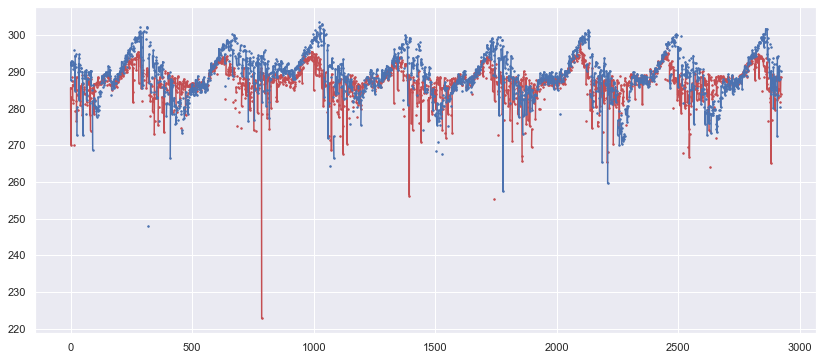

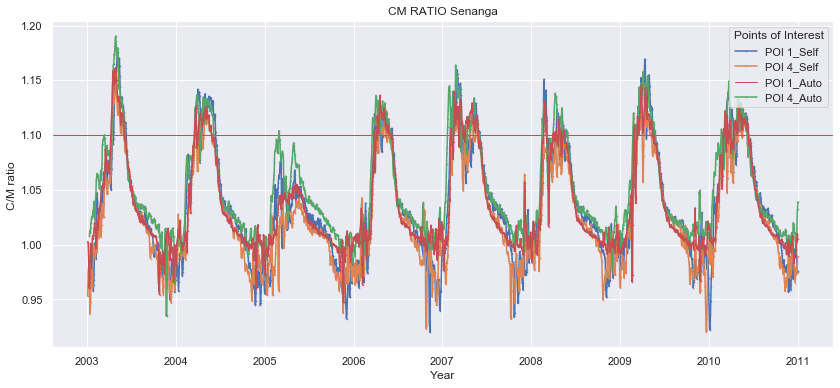

In [92]:
pointC = [(22.472987, -16.087507)]


point_xC, point_yC = zip(*pointC)
points_xM, points_yM = zip(*points_xy)
df=pd.DataFrame()
df_auto=pd.DataFrame()

ts_C = ds.sel(x=list(point_xC), y=list(point_yC), method='nearest')
ts_M = ds.sel(x=list(points_xM), y=list(points_yM), method='nearest')

# From variable 'TB' let's plot time series sequentially, for the self defined calibration cell
plt.figure(figsize=(14,6))
values_C = ts_C['TB'].values
plt.plot(values_C[:,0,0],color ='r' ,  marker='.', markersize=3)

values_M = ts_M['TB'].values
plt.plot(values_M[:,0,0],color ='b' ,  marker='.', markersize=3)



# # for n in [x for x in range(5) if x !=0 if x !=2 if x !=3]: 
# #     x_M, y_M  = points_xy[n]
# #     ts_M = ds.sel(x=list(x_M), y=list(y_M), method='nearest')
# #     values_M = ts_M['TB'].values

# #     plt.plot(values_M[:,0,0],color ='r' ,  marker='.', markersize=3)


    

# plt.show
# plot CM ratio for the self defined dry calibration cell
q_c1 = values_C[:,0,0] #dry calibration cell 1

for n in [x for x in range(5) if x !=0 if x !=2 if x !=3 ]: 
    q_m = values_M[:,n,n] 
    values_q = ((q_c1 / q_m))
    df[n] = values_q
    
    df[n].fillna(method='bfill',inplace=True)
    df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
    df[n] = df[n].rolling(5,center=False).mean() #.shift(10)  # apply and set the rolling mean to 5
    df[1] =df[1].shift(shift)   

    df.index=dates
    trigger = df.quantile([0.9, 0.95, 0.98])
plt.figure(figsize=(14,6))
plt.plot(df ,marker='.', markersize=1,label= (f'CM ratio at POI{n}- rolling median'))

df.columns = ['POI1_Self', 'POI4_Self']
   
plt.grid(True)
plt.axhline(y=1.10,linewidth=1, color='r')



for n in [x for x in range(5) if x !=0 if x !=2 if x !=3 ]: 
    x, y  = points_xy[n]
    C, M, ratio,  = nsidc.c_m_ratio(ds['TB'], x, y)
    
    df_auto[n] = ratio
    dates = ratio.time.values
    
    
    df_auto[n].fillna(method='bfill',inplace=True)
    df_auto[n][df_auto[n]<0] = df_auto[n].fillna(method='bfill',inplace=True)
    df_auto[n] = df_auto[n].rolling(5,center=False).mean() #.shift(10)  # apply and set the rolling mean to 5

    df_auto.index=dates
    trigger = df_auto.quantile([0.9, 0.95, 0.98])
    
    
    df_auto[1] =df_auto[1].shift(shift)   
    
    plt.plot(df_auto[n] ,marker='.', markersize=1,label= (f'CM ratio at POI{n}- rolling median'))
    plt.title('CM RATIO Senanga')
    plt.xlabel('Year')
    plt.ylabel('C/M ratio ')        
    plt.legend(['POI 1_Self','POI 4_Self','POI 1_Auto','POI 4_Auto'],title ='Points of Interest',fancybox=True)
df_auto.columns = ['POI1_Auto', 'POI4_Auto']

# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/CM_{location}_SelfvsAutoPOI4.png'),dpi=800)


                         QuantReg Regression Results                          
Dep. Variable:              POI4_Self   Pseudo R-squared:               0.5807
Model:                       QuantReg   Bandwidth:                     0.01110
Method:                 Least Squares   Sparsity:                      0.05752
Date:                Tue, 18 Feb 2020   No. Observations:                  962
Time:                        09:33:23   Df Residuals:                      960
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2071      0.018     11.660      0.000       0.172       0.242
POI1_Self      0.7918      0.017     47.136      0.000       0.759       0.825


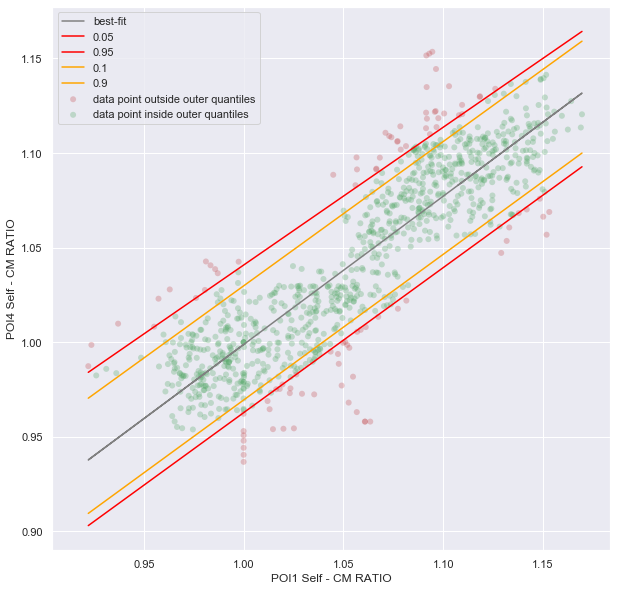

In [93]:
## Auto Assigned C Cell - QR Ratio

df.POI1_Self.fillna(1, inplace=True)
df.POI4_Self.fillna(1, inplace=True)
df= df[df.index.month>0]
df= df[df.index.month<5]





model = smf.quantreg('POI4_Self ~ POI1_Self', df)
quantiles = [0.05, 0.10, 0.90 , 0.95]
fits = [model.fit(q=q) for q in quantiles]
figure, axes = plt.subplots(figsize=(10,10))

x = df['POI1_Self']
y = df['POI4_Self']

fit = np.polyfit(x, y, deg=1)
_x = np.linspace(x.min(), x.max(), num=len(y))

res = model.fit(q=0.5)
print(res.summary())


# fit lines
_y_005 = fits[0].params['POI1_Self'] * _x + fits[0].params['Intercept']
_y_095 = fits[3].params['POI1_Self'] * _x + fits[3].params['Intercept']
_y_010 = fits[1].params['POI1_Self'] * _x + fits[1].params['Intercept']
_y_090 = fits[2].params['POI1_Self'] * _x + fits[2].params['Intercept']

# start and end coordinates of fit lines
p = np.column_stack((x, y))
a = np.array([_x[0], _y_005[0]]) #first point of 0.05 quantile fit line
b = np.array([_x[-1], _y_005[-1]]) #last point of 0.05 quantile fit line

a_ = np.array([_x[0], _y_095[0]])
b_ = np.array([_x[-1], _y_095[-1]])

a__ = np.array([_x[0], _y_010[0]]) #first point of 0.10 quantile fit line
b__ = np.array([_x[-1], _y_010[-1]]) #last point of 0.10 quantile fit line

a___ = np.array([_x[0], _y_090[0]])
b___ = np.array([_x[-1], _y_090[-1]])



#mask based on if coordinates are above 0.95 or below 0.05 quantile fitlines using cross product

mask = lambda p, a, b, a_, b_: (np.cross(p-a, b-a) > 0) | (np.cross(p-a_, b_-a_) < 0)
mask = mask(p, a, b, a_, b_)

axes.scatter(x[mask], df['POI4_Self'][mask], facecolor='r', edgecolor='none', alpha=0.3, label='data point outside outer quantiles')
axes.scatter(x[~mask], df['POI4_Self'][~mask], facecolor='g', edgecolor='none', alpha=0.3, label='data point inside outer quantiles')

axes.plot(x, fit[0] * x + fit[1], label='best-fit', c='grey')
axes.plot(_x, _y_095, label=quantiles[0], c='red')
axes.plot(_x, _y_005, label=quantiles[3], c='red')
axes.plot(_x, _y_090, label=quantiles[1], c='orange')
axes.plot(_x, _y_010, label=quantiles[2], c='orange')

# axes.title('Quantile Regression')
axes.legend()
axes.set_xlabel('POI1 Self - CM RATIO')
axes.set_ylabel('POI4 Self - CM RATIO')

# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/QR_Senanga_Self_shift{shift}.png'),dpi=400)


plt.show()




                         QuantReg Regression Results                          
Dep. Variable:              POI4_Auto   Pseudo R-squared:               0.6101
Model:                       QuantReg   Bandwidth:                     0.01021
Method:                 Least Squares   Sparsity:                      0.04741
Date:                Tue, 18 Feb 2020   No. Observations:                  962
Time:                        09:33:24   Df Residuals:                      960
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1003      0.017      5.940      0.000       0.067       0.133
POI1_Auto      0.8969      0.016     56.793      0.000       0.866       0.928


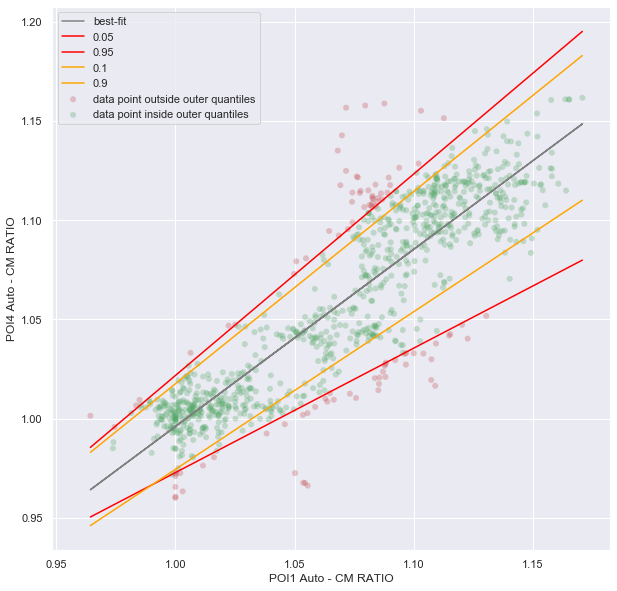

In [94]:
## Auto Assigned C Cell - QR Ratio
df_auto.POI1_Auto.fillna(1, inplace=True)
df_auto.POI4_Auto.fillna(1, inplace=True)
df_auto= df_auto[df_auto.index.month>0]
df_auto= df_auto[df_auto.index.month<5]





model = smf.quantreg('POI4_Auto ~ POI1_Auto', df_auto)
quantiles = [0.05, 0.10, 0.90 , 0.95]
fits = [model.fit(q=q) for q in quantiles]
figure, axes = plt.subplots(figsize=(10,10))

x = df_auto['POI1_Auto']
y = df_auto['POI4_Auto']

fit = np.polyfit(x, y, deg=1)
_x = np.linspace(x.min(), x.max(), num=len(y))

res = model.fit(q=0.5)
print(res.summary())


# fit lines
_y_005 = fits[0].params['POI1_Auto'] * _x + fits[0].params['Intercept']
_y_095 = fits[3].params['POI1_Auto'] * _x + fits[3].params['Intercept']
_y_010 = fits[1].params['POI1_Auto'] * _x + fits[1].params['Intercept']
_y_090 = fits[2].params['POI1_Auto'] * _x + fits[2].params['Intercept']

# start and end coordinates of fit lines
p = np.column_stack((x, y))
a = np.array([_x[0], _y_005[0]]) #first point of 0.05 quantile fit line
b = np.array([_x[-1], _y_005[-1]]) #last point of 0.05 quantile fit line

a_ = np.array([_x[0], _y_095[0]])
b_ = np.array([_x[-1], _y_095[-1]])

a__ = np.array([_x[0], _y_010[0]]) #first point of 0.10 quantile fit line
b__ = np.array([_x[-1], _y_010[-1]]) #last point of 0.10 quantile fit line

a___ = np.array([_x[0], _y_090[0]])
b___ = np.array([_x[-1], _y_090[-1]])



#mask based on if coordinates are above 0.95 or below 0.05 quantile fitlines using cross product

mask = lambda p, a, b, a_, b_: (np.cross(p-a, b-a) > 0) | (np.cross(p-a_, b_-a_) < 0)
mask = mask(p, a, b, a_, b_)

axes.scatter(x[mask], df_auto['POI4_Auto'][mask], facecolor='r', edgecolor='none', alpha=0.3, label='data point outside outer quantiles')
axes.scatter(x[~mask], df_auto['POI4_Auto'][~mask], facecolor='g', edgecolor='none', alpha=0.3, label='data point inside outer quantiles')

axes.plot(x, fit[0] * x + fit[1], label='best-fit', c='grey')
axes.plot(_x, _y_095, label=quantiles[0], c='red')
axes.plot(_x, _y_005, label=quantiles[3], c='red')
axes.plot(_x, _y_090, label=quantiles[1], c='orange')
axes.plot(_x, _y_010, label=quantiles[2], c='orange')

# axes.title('Quantile Regression')
axes.legend()
axes.set_xlabel('POI1 Auto - CM RATIO')
axes.set_ylabel('POI4 Auto - CM RATIO')

# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/›.png'),dpi=400)



plt.show()

